## Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# Libraries for read/write operations
import os
import glob
import pathlib

# Libraries for calculations
import numpy as np
import pandas as pd

# Libraries for graphical visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# If you are using the data by mounting the google drive, uncomment and use the use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# I've used my local windows based system for the assignment. Kindly update path in the variable 'local_dir_path' as required during evaluation.
# Please don't add Train and Test in the below path as it will be populated by itself as per logic in the following cell. Also the datasets extracted from 
# link has huge folder name "Skin cancer ISIC The International Skin Imaging Collaboration" and can cause issues during execution. Hence please reduce it accordingly.

dataset_dir_path = r"datasets"
local_dir_path = os.path.join(dataset_dir_path, "Skin cancer ISIC The International Skin Imaging Collaboration")

In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(f"{local_dir_path}/Train")
data_dir_test = pathlib.Path(f"{local_dir_path}/Test")

In [5]:
# List the count of images within the Train and Test Files respectively

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
# Training Dataset logic
# Initialized 'seed = 123' while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory as per instructions in the Starter Notebook

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,  # 80% sample for training and 20% for validation
    subset = 'training',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Validation Dataset logic
# Initialized 'seed = 123' while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory as per instructions in the Starter Notebook

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    image_size =(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing all the classes Names. These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

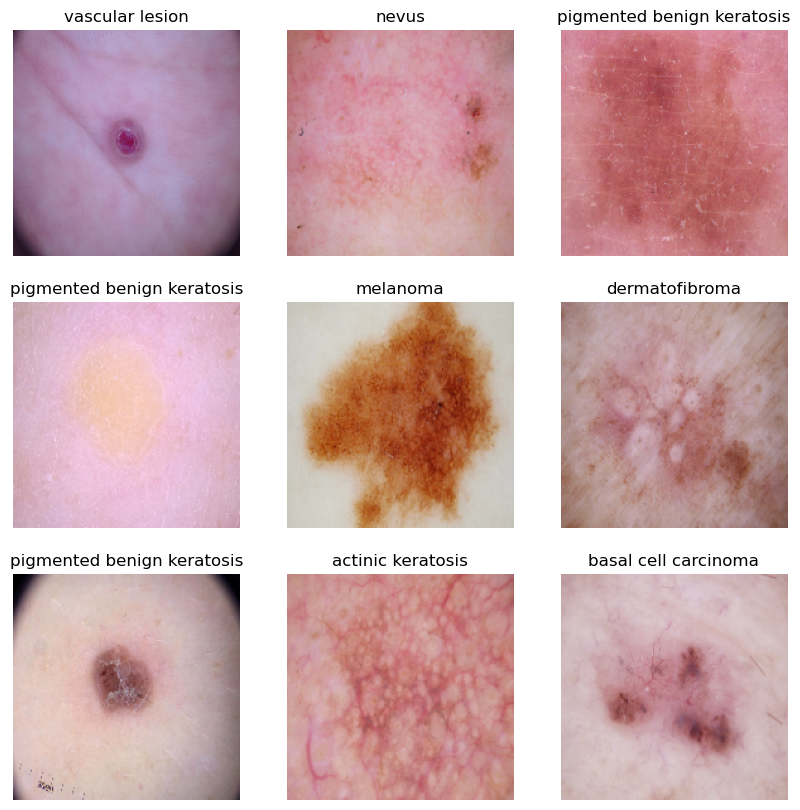

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

An **image batch** is a collection of images stacked together along the batch dimension. In **machine learning and deep learning**, models often process data in batches rather than individual samples.

For example, in a batch of images, each image might have dimensions **(height, width, channels)**, and if the batch size is **32**, the shape of the batch tensor would be **(32, height, width, channels)**. This allows the model to process multiple images simultaneously, which can improve efficiency and speed during training or inference.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


From the above cell output, it's clear that it is an image batch of **32 images** of shape **180 x 180 x 3**. 
The last dimension refers to color channels **RGB (Red, Blue, Green)**.

**AUTOTUNE** is a special value that allows TensorFlow to automatically tune the prefetch buffer size dynamically at runtime based on the available memory and other factors. 
This can help optimize the performance of your input pipeline without manually tuning the buffer size.

**Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

**Dataset.prefetch** overlaps data preprocessing and model execution while trainingg

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. 
Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.
Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Total classes are 9
num_classes = 9

model = Sequential(
    [
        tf.keras.layers.Rescaling(1. / 255, input_shape = (img_height, img_width, 3)),
        
        tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ]
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
%%time

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 8s 94ms/step - loss: 1.9545 - accuracy: 0.2690 - val_loss: 1.8182 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7425 - accuracy: 0.3672 - val_loss: 1.5293 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 5s 83ms/step - loss: 1.4862 - accuracy: 0.4788 - val_loss: 1.4858 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.3999 - accuracy: 0.5073 - val_loss: 1.3832 - val_accuracy: 0.5481
Epoch 5/20
56/56 [==============================] - 4s 79ms/step - loss: 1.2854 - accuracy: 0.5497 - val_loss: 1.5689 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 1.3216 - accuracy: 0.5229 - val_loss: 1.3758 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.1541 - accuracy: 0.5882 - val_loss: 1.4519 - val_accuracy: 0.5257
Epoch 8/20


### Visualize the results

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

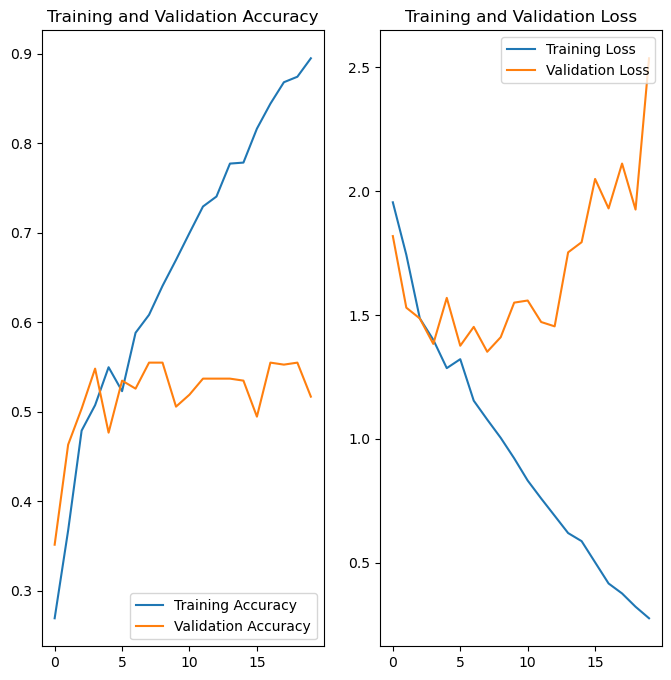

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Observations and Findings**

1. The model's training accuracy rose steadily at first but declined slightly at **$14^{th}$ epoch** and then steadily rose again upto **85%+**.
2. The model's validation accuracy was fluctuating as it first rose then declined slightly and then increased upto **50%+** .
3. The model's training loss steadily declined.
4. The model's validation loss shows a U curve shape where it declined first and then increased.
5. The model's high training accuracy and low validation accuracy indicate overfitting as it managed to capture noise and details in the data.

As a result we'll need to modify the existing training data using data Augmentation techniques which involves adjusting the data slightly by rotation, flipping, zooming in/out etc. and then train the model again.

### Augment the Training Data

In [19]:
augmented_data = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape = (img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.2, fill_mode = 'reflect'),
        layers.experimental.preprocessing.RandomZoom(0.2, fill_mode = 'reflect')
    ]
)

### Visualize the Augmented Data

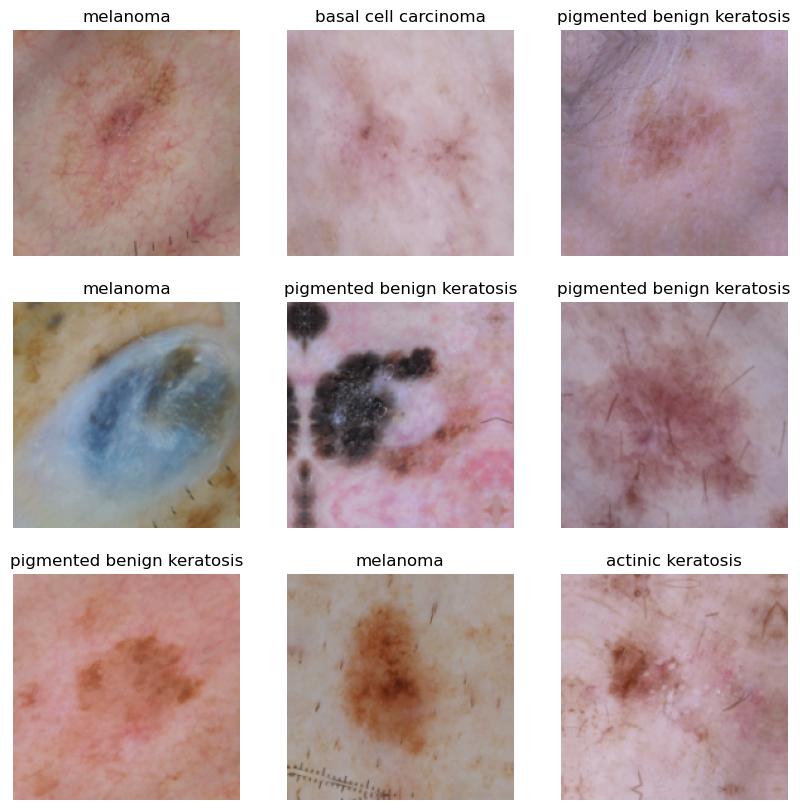

In [20]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_data(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model using Augmented Data

In [21]:
model = Sequential(
    [
        augmented_data,
        tf.keras.layers.Rescaling(1. / 255, input_shape = (img_height, img_width, 3)),
        
        tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ]
)

### Compile the Model

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Train the Model

In [23]:
%%time

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs    # Declared already in earlier coding steps so using same value here
)

Epoch 1/20
56/56 [==============================] - 7s 100ms/step - loss: 2.0939 - accuracy: 0.2450 - val_loss: 1.7718 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 5s 98ms/step - loss: 1.6468 - accuracy: 0.4113 - val_loss: 1.5158 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 6s 101ms/step - loss: 1.4911 - accuracy: 0.4810 - val_loss: 1.4389 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 6s 100ms/step - loss: 1.4152 - accuracy: 0.5017 - val_loss: 1.5203 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 6s 100ms/step - loss: 1.4302 - accuracy: 0.4950 - val_loss: 1.3512 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 6s 100ms/step - loss: 1.3415 - accuracy: 0.5140 - val_loss: 1.5148 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 6s 100ms/step - loss: 1.3466 - accuracy: 0.5218 - val_loss: 1.3458 - val_accuracy: 0.5190
Epoch 8

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Visualize the results

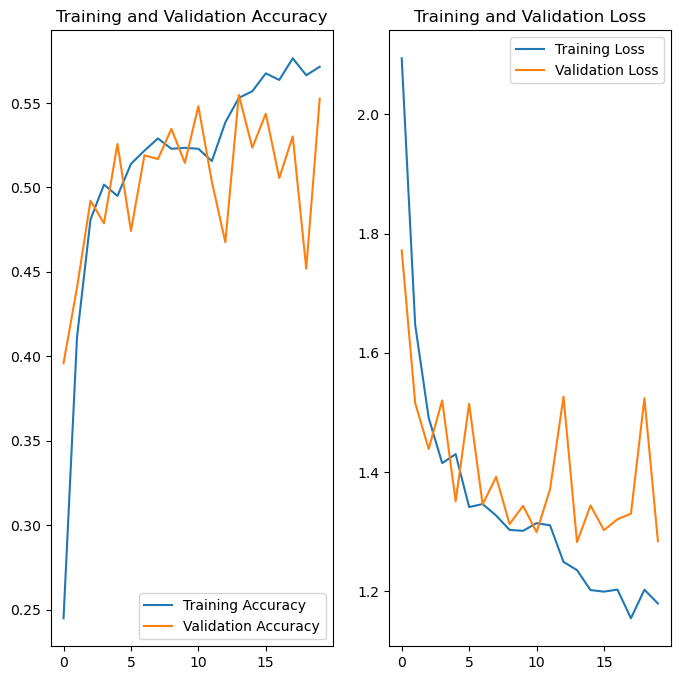

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observations and Findings**

1. The model's training and validation accuracy post data augmentation are now along similar lines.
2. The model's training loss steadily declined.
4. The model's validation loss is more compared to training loss.
5. The model's training and validation accuracies are both low thus model is underfitting.

As a result we'll now try another approach to check if these results can be improved.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
path_list = []
class_lables_list = []

In [27]:
required_images = os.path.abspath(os.path.join(data_dir_train, '**/*.jpg'))
list_of_images = glob.glob(required_images, recursive = True)

In [28]:
for image in list_of_images:
    class_label = os.path.basename(os.path.dirname(image))
    class_lables_list.append(class_label)
    path_list.append(image)

In [29]:
class_labels_path_df = pd.DataFrame(
    dict(
        class_label = class_lables_list,
        image_path = path_list
    )
)
class_labels_path_df

,class_label,image_path
0,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
1,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
2,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
3,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
4,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
...,...,...
2234,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
2235,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
2236,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
2237,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...


### Visualize the Class Distribution

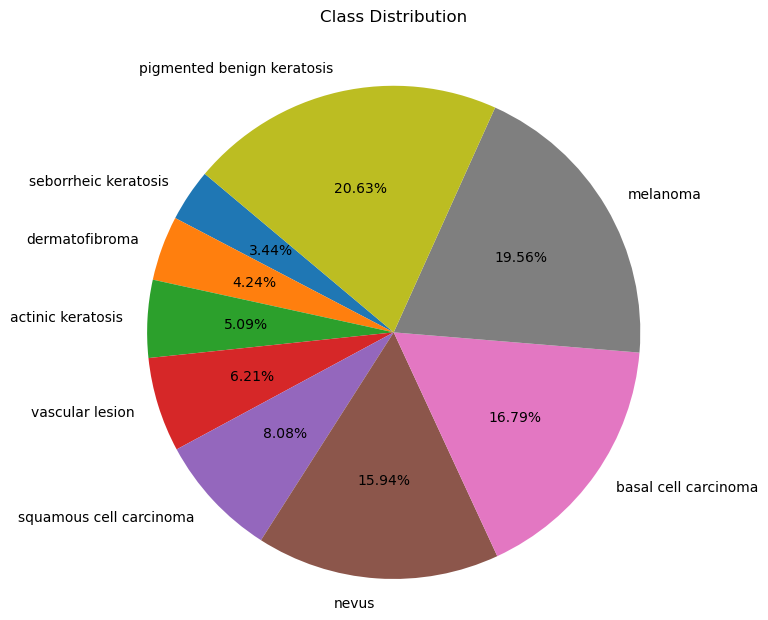

In [30]:
# Pie Chart to visualize percenatge wise class distribution

plt.figure(figsize = (7, 7))
class_distribution_value_counts = class_labels_path_df.class_label.value_counts(ascending = True)
plt.pie(class_distribution_value_counts.values, labels = class_distribution_value_counts.index, autopct='%.2f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Class Distribution', pad=30, loc='center')
plt.show()

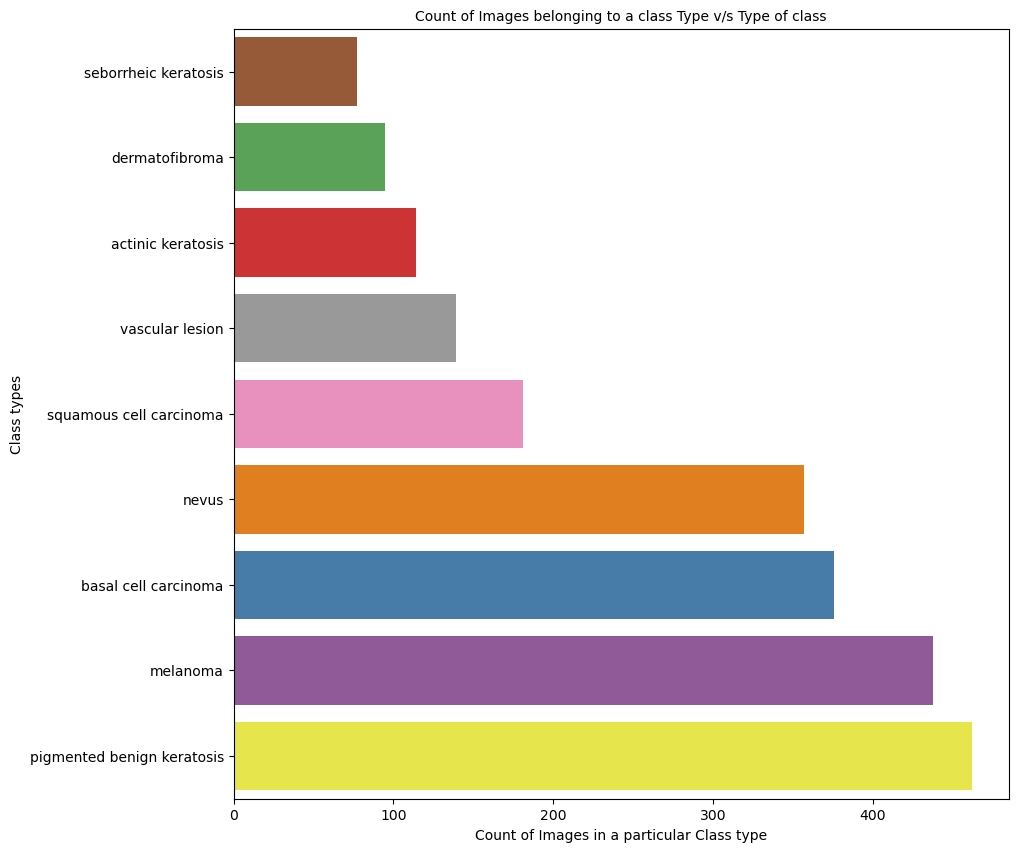

In [31]:
# Seaborn Count Plot to visualize class distribution

plt.figure(figsize = (10, 10))
sns.countplot(y = "class_label", data = class_labels_path_df, order=class_distribution_value_counts.index, palette = "Set1", hue = "class_label")
plt.xlabel('Count of Images in a particular Class type', fontsize = 10)
plt.ylabel('Class types', fontsize = 10)
plt.title('Count of Images belonging to a class Type v/s Type of class', fontsize = 10)
plt.show()

#### Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

**Observations and Findings:**
- Based upon the above visualizations we can see that there's a clear case of class imbalance.
- **seborrheic keratosis** class has the least number of samples (**3.44%**).
- **pigmented benign keratosis** with **20.63%** dominates the classes followed by **melanoma** with **19.56%**.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.
hod.hod.hod.

In [33]:
# I was facing issues due to long path of the datasets. Hence if it doesn't work then shorten the paths and proceed accordingly.

path_to_training_dataset = str(data_dir_train) + "/"

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,save_format='jpg')
    p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2131254F150>: 100%|█| 500/500 [00:01<00:00, 289.09 Samples


Initialised with 376 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2130FD39890>: 100%|█| 500/500 [00:01<00:00, 290.62 Samples


Initialised with 95 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21324B75C10>: 100%|█| 500/500 [00:01<00:00, 285.36 Samples


Initialised with 438 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x21312433C90>: 100%|█| 500/500 [00:10<00:00, 47.28 Sample


Initialised with 357 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x21313946050>: 100%|█| 500/500 [00:09<00:00, 55.44 Samples/


Initialised with 462 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2131254DDD0>: 100%|█| 500/500 [00:01<00:


Initialised with 77 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2130F3A4CD0>: 100%|█| 500/500 [00:04<00


Initialised with 181 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x213263EBC90>: 100%|█| 500/500 [00:01<00:00, 285.45 Samples


Initialised with 139 image(s) found.
Output directory set to datasets\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21313837CD0>: 100%|█| 500/500 [00:01<00:00, 265.81 Samples


In [34]:
# check total number of images after data augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [35]:
path_list_new = []
class_lables_list_new = []

In [36]:
required_images_new = os.path.abspath(os.path.join(data_dir_train, "*", "output", "*.jpg"))
list_of_images_new = glob.glob(required_images_new)

In [37]:
for image_new in list_of_images_new:
    class_label_new = os.path.basename(os.path.dirname(os.path.dirname(image_new)))
    class_lables_list_new.append(class_label_new)
    path_list_new.append(image_new)

In [38]:
class_labels_path_df_new = pd.DataFrame(
    dict(
        class_label = class_lables_list_new,
        image_path = path_list_new
    )
)
class_labels_path_df_new

,class_label,image_path
0,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
1,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
2,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
3,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
4,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
...,...,...
4495,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
4496,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
4497,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
4498,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...


In [39]:
class_labels_path_df

,class_label,image_path
0,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
1,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
2,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
3,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
4,actinic keratosis,D:\Melanoma_Detection_Assignment\datasets\Skin...
...,...,...
2234,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
2235,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
2236,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...
2237,vascular lesion,D:\Melanoma_Detection_Assignment\datasets\Skin...


In [40]:
class_labels_path_df_final = pd.concat(
    [class_labels_path_df, class_labels_path_df_new], axis = 0
)

In [41]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Visualize the Class Distribution post using Augmentor

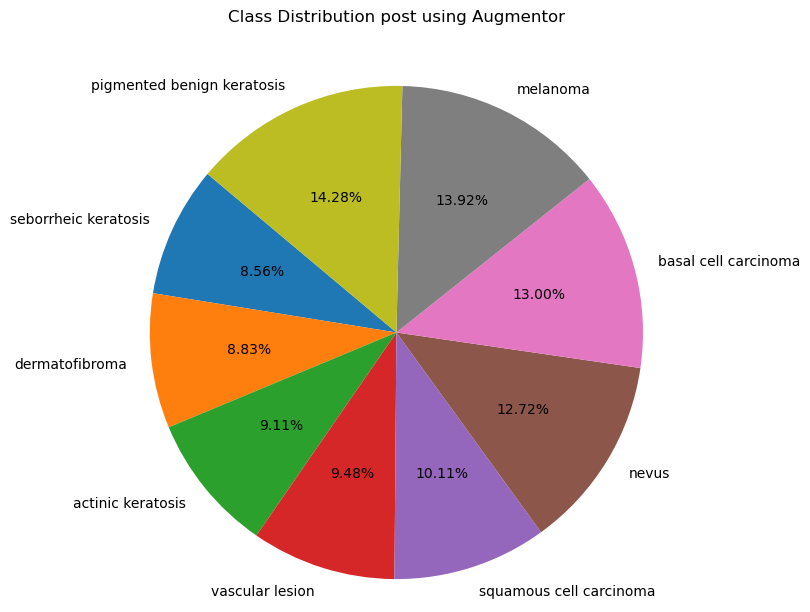

In [42]:
# Pie Chart to visualize percenatge wise class distribution

plt.figure(figsize = (7, 7))
class_distribution_final_value_counts = class_labels_path_df_final.class_label.value_counts(ascending = True)
plt.pie(class_distribution_final_value_counts.values, labels = class_distribution_final_value_counts.index, autopct='%.2f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Class Distribution post using Augmentor', pad=30, loc='center')
plt.show()

From the above pie chart it's clear that the addition of 500 images to each class solved the class imablance problem to a lot extent.

### Train the model on the data created using Augmentor

### Create a training dataset

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Here this path is old + augmented images
    seed = 123,
    validation_split = 0.2,
    subset = "training",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [45]:
model = Sequential(
    [
        augmented_data,
        layers.experimental.preprocessing.Rescaling(1./255),
        
        layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Dropout(0.2),
        layers.Flatten(),
        
        layers.Dense(128, activation = 'relu'),
        layers.Dense(num_classes)
])

### Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Train the Model

In [47]:
%%time
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs    # Declared already in earlier coding steps so using same value here
)

Epoch 1/20
169/169 [==============================] - 28s 159ms/step - loss: 2.3904 - accuracy: 0.3238 - val_loss: 17.2914 - val_accuracy: 0.1084
Epoch 2/20
169/169 [==============================] - 25s 147ms/step - loss: 1.6728 - accuracy: 0.3663 - val_loss: 8.7958 - val_accuracy: 0.1366
Epoch 3/20
169/169 [==============================] - 25s 147ms/step - loss: 1.5854 - accuracy: 0.3973 - val_loss: 2.2437 - val_accuracy: 0.2539
Epoch 4/20
169/169 [==============================] - 25s 147ms/step - loss: 1.5112 - accuracy: 0.4366 - val_loss: 1.7986 - val_accuracy: 0.3348
Epoch 5/20
169/169 [==============================] - 25s 150ms/step - loss: 1.4106 - accuracy: 0.4479 - val_loss: 1.5668 - val_accuracy: 0.4291
Epoch 6/20
169/169 [==============================] - 25s 148ms/step - loss: 1.4013 - accuracy: 0.4611 - val_loss: 1.6016 - val_accuracy: 0.4143
Epoch 7/20
169/169 [==============================] - 26s 154ms/step - loss: 1.3596 - accuracy: 0.4666 - val_loss: 2.2131 - val_a

In [48]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

### Visualize the model results

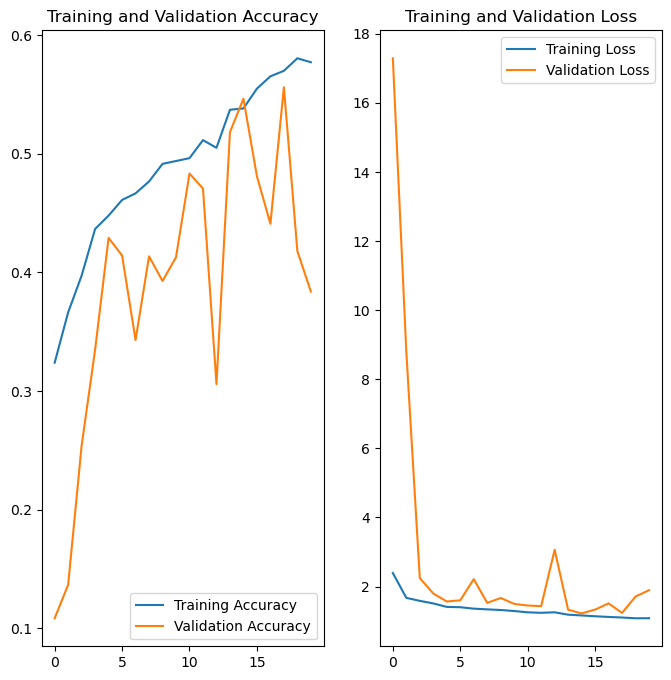

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations and Findings:**
- Based upon the above visualizations we can see that batch normalization with addressing class imabance did not majorly contribute to improving training and validation accuracy.
- It only brought slight increase but not too much in the accuracies.
- However the validation loss was huge at the beginning but reduced significantly.
- We'll try now without batch normalization to see if it offers some new findings.

### Create another model without batch normalization using augmented data

In [50]:
model = Sequential(
    [
        augmented_data,
        layers.experimental.preprocessing.Rescaling(1./255),
        
        layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
        layers.MaxPooling2D(),
        
        layers.Dropout(0.2),
        layers.Flatten(),
        
        layers.Dense(128, activation = 'relu'),
        layers.Dense(num_classes)
])

### Compile your model (Choose optimizer and loss function appropriately)

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Train the Model

In [52]:
%%time
epochs = 50
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/50
169/169 [==============================] - 32s 177ms/step - loss: 1.9716 - accuracy: 0.2517 - val_loss: 1.6921 - val_accuracy: 0.3890
Epoch 2/50
169/169 [==============================] - 30s 173ms/step - loss: 1.5438 - accuracy: 0.4008 - val_loss: 1.4428 - val_accuracy: 0.4380
Epoch 3/50
169/169 [==============================] - 28s 162ms/step - loss: 1.4510 - accuracy: 0.4473 - val_loss: 1.4204 - val_accuracy: 0.4796
Epoch 4/50
169/169 [==============================] - 28s 162ms/step - loss: 1.3942 - accuracy: 0.4490 - val_loss: 1.3905 - val_accuracy: 0.4699
Epoch 5/50
169/169 [==============================] - 28s 161ms/step - loss: 1.3256 - accuracy: 0.4809 - val_loss: 1.3265 - val_accuracy: 0.4870
Epoch 6/50
169/169 [==============================] - 28s 163ms/step - loss: 1.3114 - accuracy: 0.4881 - val_loss: 1.3629 - val_accuracy: 0.4900
Epoch 7/50
169/169 [==============================] - 29s 167ms/step - loss: 1.2561 - accuracy: 0.5095 - val_loss: 1.2650 - val_ac

### View the model stats

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

### Visualize the model results

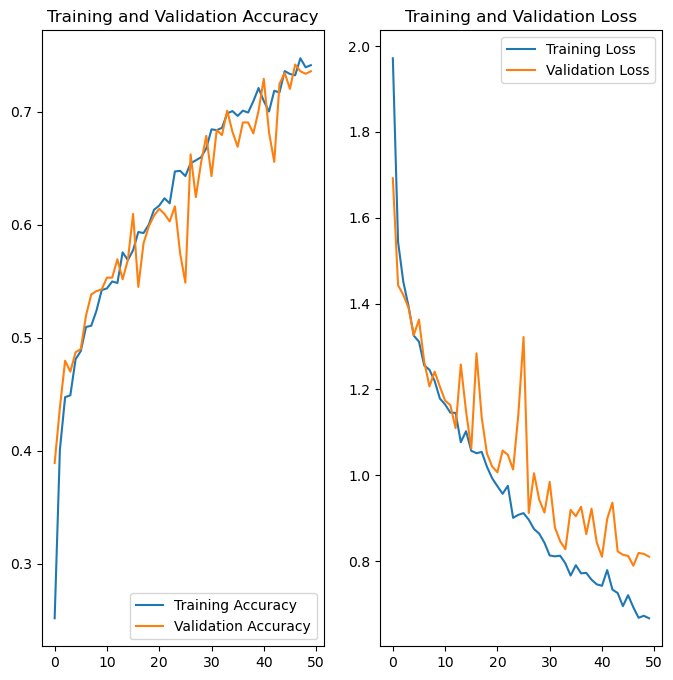

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations and Findings:**
- Based upon the above visualizations we can see that addressing class imablance without batch normalization significantly improved training and validation accuracies.
- Training and validation accuracies are along same lines.
- Training and validation losses are along same lines too.
- Overfitting and Underfitting issues were also addressed.
- Training and validation accuracies are above **70%**

### Model Evaluation

We'll evaluate our final model on few of the random class samples from the test set.

In [55]:
def evaluate_random_samples(input_class_sample: int)-> None:
    """ Helper function to predict model output"""

    unseen_image_sample_path_test = os.path.join(data_dir_test, class_names[input_class_sample], '*')
    unseen_test_sample_image = glob.glob(unseen_image_sample_path_test)
    unseen_test_sample_image = load_img(unseen_test_sample_image[input_class_sample], target_size=(img_height, img_width, 3))
    plt.imshow(unseen_test_sample_image)
    plt.grid(False) # No bordering grid required
    
    img = np.expand_dims(unseen_test_sample_image, axis=0)
    predicted = model.predict(img)
    predicted = np.argmax(predicted)
    predicted_class = class_names[predicted]
    
    print("Actual Class: " + class_names[input_class_sample] +'\n'+ "Predicted Class: " + predicted_class) 

1/1 [==============================] - 0s 31ms/step
Actual Class: nevus
Predicted Class: nevus


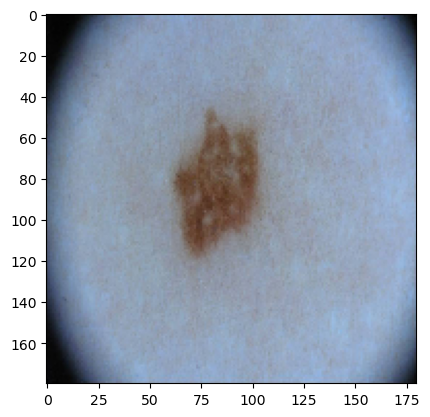

In [57]:
evaluate_random_samples(4)